<a href="https://colab.research.google.com/github/soumilidas03/deepLearning/blob/main/Lung_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing libraries**

In [ ]:
!pip install torch torchvision albumentations segmentation-models-pytorch kagglehub matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.2 MB/s eta 0:00:00


**Accessing dataset and getting images and masks**

In [ ]:
from glob import glob

# Path to Drive
path = "/content/drive/MyDrive/lung_segmentation_dataset/1"

# Get images and masks
train_imgs = sorted(glob(path + "/Chest-X-Ray/Chest-X-Ray/image/*.png"))
train_masks = sorted(glob(path + "/Chest-X-Ray/Chest-X-Ray/mask/*.png"))

print("Total images:", len(train_imgs))
print("Total masks:", len(train_masks))


Total images: 704
Total masks: 704


**Splitting into train test validation**

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test first (15% test)
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    train_imgs, train_masks, test_size=0.15, random_state=42
)

# Now split train into train and validation (15% of train → ~12% of total)
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    train_imgs, train_masks, test_size=0.15, random_state=42
)

print("Training size:", len(train_imgs))
print("Validation size:", len(val_imgs))
print("Test size:", len(test_imgs))


Training size: 508
Validation size: 90
Test size: 106


**Creating train test datasets and loaders and dividing into batches**

In [ ]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define Dataset Class
class LungSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Normalize
        img = img / 255.0
        mask = mask / 255.0

        # Expand dimensions for image (HxW → HxWx1)
        img = np.expand_dims(img, axis=-1)
        # Remove channel dimension for mask (HxWx1 → HxW) if it exists
        if mask.ndim == 3 and mask.shape[-1] == 1:
            mask = mask.squeeze(axis=-1)


        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        return img.float(), mask.float()

# Augmentations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

# Create datasets
train_dataset = LungSegmentationDataset(train_imgs, train_masks, transform=transform)
val_dataset = LungSegmentationDataset(val_imgs, val_masks, transform=A.Compose([A.Resize(256,256), ToTensorV2()]))
test_dataset = LungSegmentationDataset(test_imgs, test_masks, transform=A.Compose([A.Resize(256,256), ToTensorV2()]))

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 64
Val batches: 12
Test batches: 14


Train batches: 64
Val batches: 12
Test batches: 14


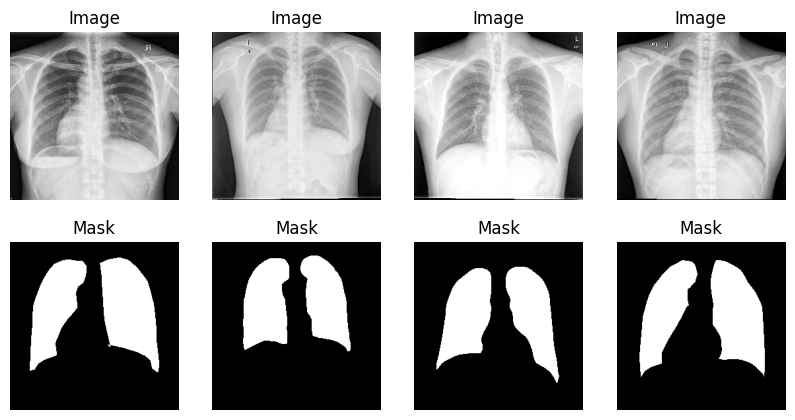

In [ ]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# -----------------------------
# Dataset Class
# -----------------------------
class LungSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Normalize
        img = img / 255.0
        mask = mask / 255.0

        # Expand dimensions for image (HxW → HxWx1)
        img = np.expand_dims(img, axis=-1)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        # Ensure mask has shape (1, H, W)
        return img.float(), mask.unsqueeze(0).float()

# -----------------------------
# Transforms
# -----------------------------
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

# -----------------------------
# Datasets
# -----------------------------
train_dataset = LungSegmentationDataset(train_imgs, train_masks, transform=train_transform)
val_dataset = LungSegmentationDataset(val_imgs, val_masks, transform=val_test_transform)
test_dataset = LungSegmentationDataset(test_imgs, test_masks, transform=val_test_transform)

# -----------------------------
# Data Loaders
# -----------------------------
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

# -----------------------------
# Sanity Check (Visualize a Batch)
# -----------------------------
def show_batch(loader):
    imgs, masks = next(iter(loader))
    imgs = imgs[:4]  # show first 4
    masks = masks[:4]

    plt.figure(figsize=(10, 5))
    for i in range(4):
        # Image
        plt.subplot(2, 4, i+1)
        plt.imshow(imgs[i].squeeze().cpu(), cmap="gray")
        plt.axis("off")
        plt.title("Image")

        # Mask
        plt.subplot(2, 4, i+5)
        plt.imshow(masks[i].squeeze().cpu(), cmap="gray")
        plt.axis("off")
        plt.title("Mask")

    plt.show()

# Run check
show_batch(train_loader)


**U-Net, training loop, validation, save + test visualization**

Device: cuda


Train Epoch 1: 100%|██████████| 64/64 [05:04<00:00,  4.77s/it]


Epoch [1/10]  Train Loss: 0.6056  Train Dice: 0.8702  Val Loss: 0.4842  Val Dice: 0.9187
-> Saved best model with Val Dice: 0.9186904380718867


Train Epoch 2: 100%|██████████| 64/64 [02:31<00:00,  2.37s/it]


Epoch [2/10]  Train Loss: 0.4150  Train Dice: 0.9417  Val Loss: 0.3935  Val Dice: 0.9399
-> Saved best model with Val Dice: 0.9398985256751379


Train Epoch 3: 100%|██████████| 64/64 [02:30<00:00,  2.36s/it]


Epoch [3/10]  Train Loss: 0.3662  Train Dice: 0.9479  Val Loss: 0.3292  Val Dice: 0.9623
-> Saved best model with Val Dice: 0.9622654765844345


Train Epoch 4: 100%|██████████| 64/64 [02:29<00:00,  2.33s/it]


Epoch [4/10]  Train Loss: 0.3185  Train Dice: 0.9564  Val Loss: 0.2884  Val Dice: 0.9629
-> Saved best model with Val Dice: 0.9629439810911814


Train Epoch 5: 100%|██████████| 64/64 [02:27<00:00,  2.31s/it]


Epoch [5/10]  Train Loss: 0.2893  Train Dice: 0.9570  Val Loss: 0.2581  Val Dice: 0.9649
-> Saved best model with Val Dice: 0.9648644775152206


Train Epoch 6: 100%|██████████| 64/64 [02:27<00:00,  2.30s/it]


Epoch [6/10]  Train Loss: 0.2673  Train Dice: 0.9575  Val Loss: 0.2455  Val Dice: 0.9618


Train Epoch 7: 100%|██████████| 64/64 [02:25<00:00,  2.27s/it]


Epoch [7/10]  Train Loss: 0.2447  Train Dice: 0.9590  Val Loss: 0.2144  Val Dice: 0.9666
-> Saved best model with Val Dice: 0.9665830632050832


Train Epoch 8: 100%|██████████| 64/64 [02:28<00:00,  2.32s/it]


Epoch [8/10]  Train Loss: 0.2252  Train Dice: 0.9603  Val Loss: 0.2049  Val Dice: 0.9668
-> Saved best model with Val Dice: 0.9668252617120743


Train Epoch 9: 100%|██████████| 64/64 [02:28<00:00,  2.31s/it]


Epoch [9/10]  Train Loss: 0.2105  Train Dice: 0.9605  Val Loss: 0.1936  Val Dice: 0.9657


Train Epoch 10: 100%|██████████| 64/64 [02:25<00:00,  2.28s/it]


Epoch [10/10]  Train Loss: 0.2032  Train Dice: 0.9585  Val Loss: 0.1702  Val Dice: 0.9687
-> Saved best model with Val Dice: 0.9686872065067291
Training finished. Best Val Dice: 0.9686872065067291


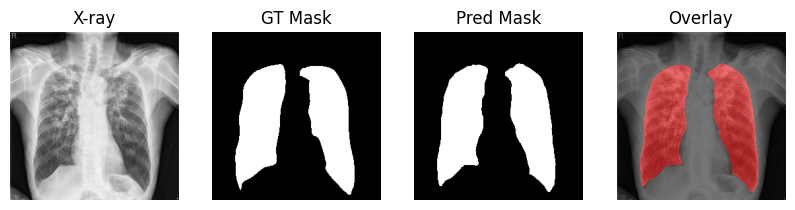

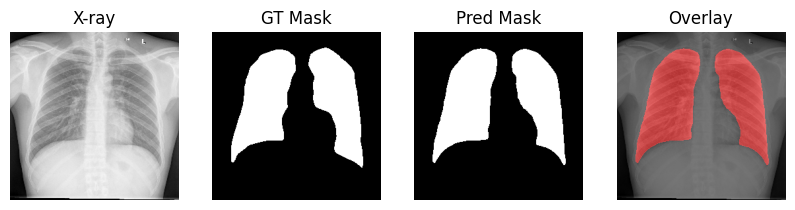

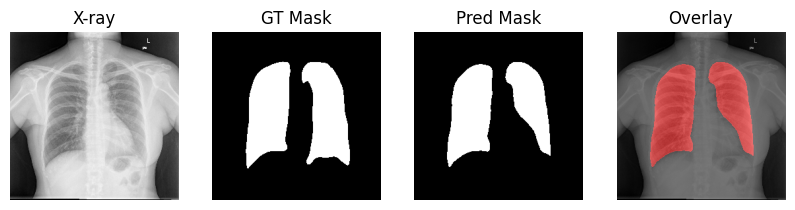

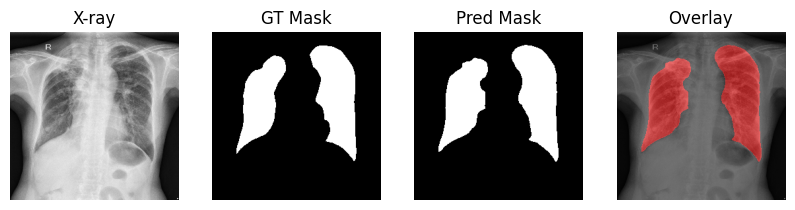

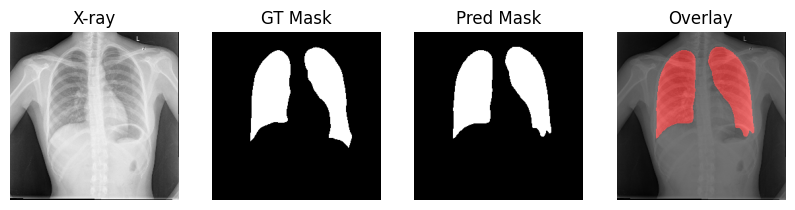

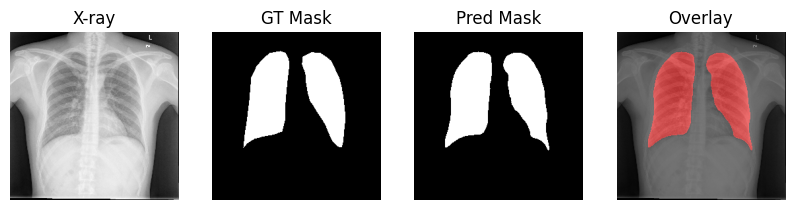

In [ ]:
# -------------------------------
# U-Net, training loop, validation, save + test visualization
# -------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

# ---------- Model (U-Net) ----------
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.center = CBR(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        center = self.center(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(center), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.out(d1))

# ---------- Metrics / Loss ----------
def dice_coeff(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    inter = (pred * target).sum()
    return (2. * inter + smooth) / (pred.sum() + target.sum() + smooth)

def dice_loss(pred, target):
    return 1 - dice_coeff(pred, target)

# ---------- Setup ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Path to save best model
save_dir = "/content/drive/MyDrive/lung_segmentation_project"
os.makedirs(save_dir, exist_ok=True)
best_path = os.path.join(save_dir, "unet_best.pth")

# ---------- Training loop ----------
num_epochs = 10   # increase later (20-30) if you want
best_val_dice = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        imgs = imgs.to(device)            # shape (B,1,H,W)
        masks = masks.to(device)          # shape (B,1,H,W)

        preds = model(imgs)
        loss = criterion(preds, masks) + dice_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coeff((preds>0.5).float(), masks).item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks) + dice_loss(preds, masks)
            val_loss += loss.item()
            val_dice += dice_coeff((preds>0.5).float(), masks).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Train Dice: {train_dice:.4f}  "
          f"Val Loss: {val_loss:.4f}  Val Dice: {val_dice:.4f}")

    # Save best (based on val dice)
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), best_path)
        print("-> Saved best model with Val Dice:", best_val_dice)

print("Training finished. Best Val Dice:", best_val_dice)

# ---------- Load best model ----------
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

# ---------- Test-time visualization ----------
def visualize_predictions(model, loader, n=6):
    model.eval()
    imgs_shown = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            preds_bin = (preds > 0.5).float()

            batch_size = imgs.shape[0]
            for i in range(batch_size):
                img_np = imgs[i].cpu().squeeze().numpy()
                mask_np = masks[i].cpu().squeeze().numpy()
                pred_np = preds_bin[i].cpu().squeeze().numpy()

                # overlay
                overlay = np.stack([img_np]*3, axis=-1)
                overlay = (overlay - overlay.min()) / (overlay.max() - overlay.min() + 1e-8)
                color_mask = np.zeros_like(overlay)
                color_mask[..., 0] = pred_np   # red channel for predicted mask
                blended = overlay.copy()
                alpha = 0.5
                blended = (1-alpha)*overlay + alpha*color_mask

                plt.figure(figsize=(10,3))
                plt.subplot(1,4,1); plt.imshow(img_np, cmap='gray'); plt.title("X-ray"); plt.axis('off')
                plt.subplot(1,4,2); plt.imshow(mask_np, cmap='gray'); plt.title("GT Mask"); plt.axis('off')
                plt.subplot(1,4,3); plt.imshow(pred_np, cmap='gray'); plt.title("Pred Mask"); plt.axis('off')
                plt.subplot(1,4,4); plt.imshow(blended); plt.title("Overlay"); plt.axis('off')
                plt.show()

                imgs_shown += 1
                if imgs_shown >= n:
                    return

# visualize n examples from test set
visualize_predictions(model, test_loader, n=6)


**Minimal setup after session restart**

Device: cuda
Model loaded successfully!


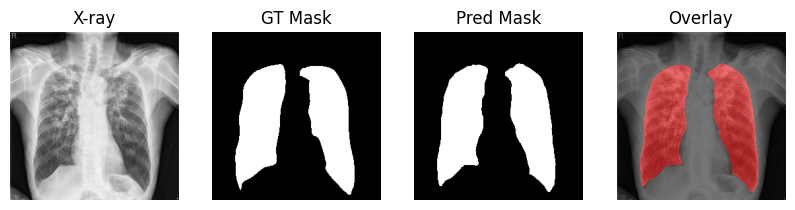

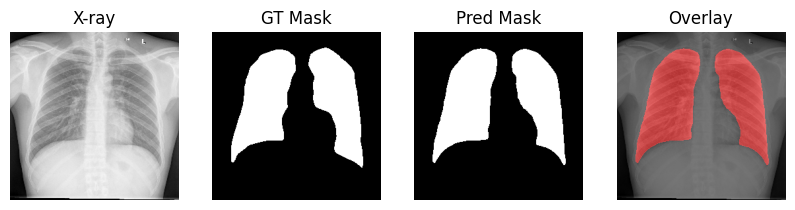

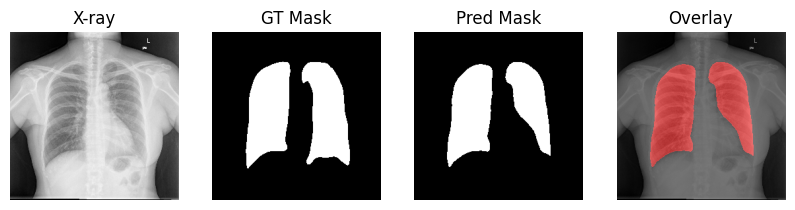

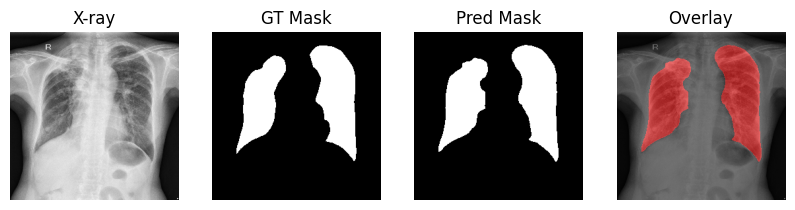

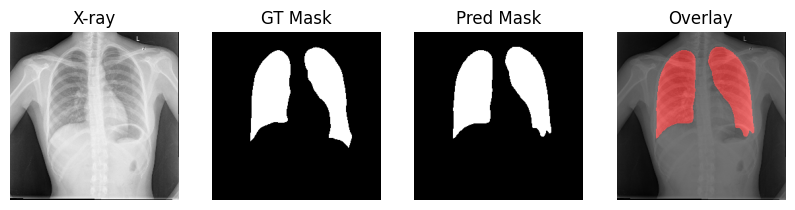

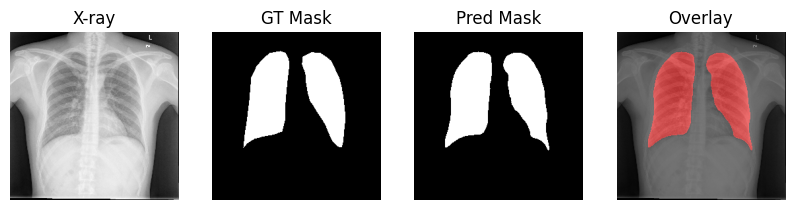

In [ ]:
# -------------------------------
# Minimal setup after session restart
# -------------------------------
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# ---------- Define U-Net class ----------
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.center = CBR(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        center = self.center(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(center), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.out(d1))

# ---------- Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- Load model ----------
model = UNet().to(device)
best_path = "/content/drive/MyDrive/lung_segmentation_project/unet_best.pth"
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()
print("Model loaded successfully!")

# ---------- Test visualization ----------
def visualize_predictions(model, loader, n=6):
    model.eval()
    imgs_shown = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            preds_bin = (preds > 0.5).float()

            batch_size = imgs.shape[0]
            for i in range(batch_size):
                img_np = imgs[i].cpu().squeeze().numpy()
                mask_np = masks[i].cpu().squeeze().numpy()
                pred_np = preds_bin[i].cpu().squeeze().numpy()

                overlay = np.stack([img_np]*3, axis=-1)
                overlay = (overlay - overlay.min()) / (overlay.max() - overlay.min() + 1e-8)
                color_mask = np.zeros_like(overlay)
                color_mask[..., 0] = pred_np
                blended = (1-0.5)*overlay + 0.5*color_mask

                plt.figure(figsize=(10,3))
                plt.subplot(1,4,1); plt.imshow(img_np, cmap='gray'); plt.title("X-ray"); plt.axis('off')
                plt.subplot(1,4,2); plt.imshow(mask_np, cmap='gray'); plt.title("GT Mask"); plt.axis('off')
                plt.subplot(1,4,3); plt.imshow(pred_np, cmap='gray'); plt.title("Pred Mask"); plt.axis('off')
                plt.subplot(1,4,4); plt.imshow(blended); plt.title("Overlay"); plt.axis('off')
                plt.show()

                imgs_shown += 1
                if imgs_shown >= n:
                    return

# ---------- Run visualization ----------
# Make sure you have your test_loader defined
visualize_predictions(model, test_loader, n=6)


**Imports and Device Setup (mandatory every restart)**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import random
import numpy as np

# ---------- Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- Reproducibility ----------
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)


Device: cuda


**Paths and CSV Setup (mandatory every restart)**

In [ ]:
# Paths
csv_path = "/content/drive/MyDrive/lung_segmentation_dataset/1/MetaData.csv"  # your CSV
images_dir = "/content/drive/MyDrive/lung_segmentation_dataset/1/Chest-X-Ray/Chest-X-Ray/image"    # original X-rays
masked_lungs_dir = "/content/drive/MyDrive/lung_segmentation_project/masked_lungs_by_class"
os.makedirs(masked_lungs_dir, exist_ok=True)

# Read CSV and create labels_dict
df = pd.read_csv(csv_path)
df['image_name'] = df['id'].astype(str) + ".png"   # match image filenames
labels_dict = dict(zip(df['image_name'], df['ptb']))  # 0=Normal, 1=TB


**Split dataset (mandatory)**

In [ ]:
image_names = list(labels_dict.keys())
labels = [labels_dict[name] for name in image_names]

# Train/Val/Test split (15% test, 15% val from train)
train_val_imgs, test_imgs, train_val_labels, test_labels = train_test_split(
    image_names, labels, test_size=0.15, random_state=42, stratify=labels
)

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    train_val_imgs, train_val_labels, test_size=0.15, random_state=42, stratify=train_val_labels
)

print("Training size:", len(train_imgs))
print("Validation size:", len(val_imgs))
print("Test size:", len(test_imgs))


Training size: 508
Validation size: 90
Test size: 106


**U-Net Definition & Load Model (mandatory)**

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.center = CBR(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.out = nn.Conv2d(64, 1, kernel_size=1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        center = self.center(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(center), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.out(d1))

# Load trained U-Net
model = UNet().to(device)
best_path = "/content/drive/MyDrive/lung_segmentation_project/unet_best.pth"
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()
print("U-Net loaded!")


U-Net loaded!


**Dataset & DataLoader (mandatory)**

In [ ]:
class LungDataset(Dataset):
    def __init__(self, img_names, root_dir, transform=None):
        self.img_names = img_names
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.img_names)
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, img_name

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

train_dataset = LungDataset(train_imgs, images_dir, transform=transform)
val_dataset = LungDataset(val_imgs, images_dir, transform=transform)
test_dataset = LungDataset(test_imgs, images_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


**Save Masked Lungs (optional if already saved)**

In [ ]:
# Create class folders for 2 classes
for split in ['train','val','test']:
    for label in [0,1]:
        os.makedirs(os.path.join(masked_lungs_dir, split, str(label)), exist_ok=True)

def save_masked_lungs(loader_split, split_name):
    with torch.no_grad():
        for batch_idx, (imgs, img_names) in enumerate(loader_split):
            imgs = imgs.to(device)
            preds = model(imgs)
            preds_bin = (preds > 0.5).float()
            for i in range(imgs.size(0)):
                img_name = img_names[i]
                label = labels_dict[img_name]
                save_path = os.path.join(masked_lungs_dir, split_name, str(label), img_name)
                masked_lung = imgs[i] * preds_bin[i]
                save_image(masked_lung, save_path)

# Save all splits
save_masked_lungs(train_loader, "train")
save_masked_lungs(val_loader, "val")
save_masked_lungs(test_loader, "test")
print("Masked lungs saved for 2-class classification!")


Masked lungs saved for 2-class classification!


**Classification**

**Imports + Device (mandatory)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


**Paths + Dataset (mandatory)**

In [ ]:
masked_lungs_dir = "/content/drive/MyDrive/lung_segmentation_project/masked_lungs_by_class"

# ImageFolder expects:
# masked_lungs_by_class/
#     train/
#         0/  # Normal
#         1/  # TB
#     val/
#         0/
#         1/
#     test/
#         0/
#         1/

# Transforms for ResNet
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),  # convert 1 channel -> 3 channels for ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

train_dataset = datasets.ImageFolder(os.path.join(masked_lungs_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(masked_lungs_dir, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(masked_lungs_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Number of classes:", len(train_dataset.classes))


Number of classes: 2


**Model Setup (mandatory)**

In [ ]:
# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Normal, TB

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


**Loss + Optimizer (mandatory)**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


**Training Loop**

In [ ]:
num_epochs = 10  # adjust as needed

best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(masked_lungs_dir, "best_classifier.pth"))
        print("-> Saved best model with Val Acc:", best_val_acc)

print("Training finished. Best Val Acc:", best_val_acc)


Epoch [1/10]  Train Loss: 0.4717  Train Acc: 0.7854  Val Acc: 0.6667
-> Saved best model with Val Acc: 0.6666666666666666
Epoch [2/10]  Train Loss: 0.2222  Train Acc: 0.9114  Val Acc: 0.8889
-> Saved best model with Val Acc: 0.8888888888888888
Epoch [3/10]  Train Loss: 0.1130  Train Acc: 0.9606  Val Acc: 0.8778
Epoch [4/10]  Train Loss: 0.0491  Train Acc: 0.9843  Val Acc: 0.8222
Epoch [5/10]  Train Loss: 0.0769  Train Acc: 0.9665  Val Acc: 0.7889
Epoch [6/10]  Train Loss: 0.0649  Train Acc: 0.9744  Val Acc: 0.8444
Epoch [7/10]  Train Loss: 0.0736  Train Acc: 0.9705  Val Acc: 0.8667
Epoch [8/10]  Train Loss: 0.0620  Train Acc: 0.9744  Val Acc: 0.8556
Epoch [9/10]  Train Loss: 0.0336  Train Acc: 0.9921  Val Acc: 0.8556
Epoch [10/10]  Train Loss: 0.0374  Train Acc: 0.9862  Val Acc: 0.8333
Training finished. Best Val Acc: 0.8888888888888888


**Test Accuracy / Predictions (mandatory after training)**

In [ ]:
# Load best model
model.load_state_dict(torch.load(os.path.join(masked_lungs_dir, "best_classifier.pth"), map_location=device))
model.eval()

test_correct, test_total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total
print("Test Accuracy:", test_acc)


Test Accuracy: 0.8018867924528302


**Visualize Predictions (optional, restart-safe)**

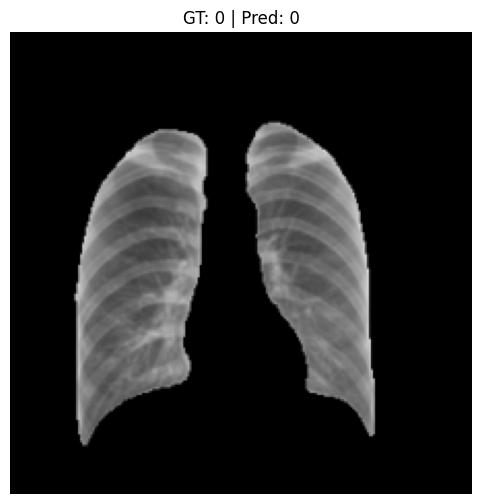

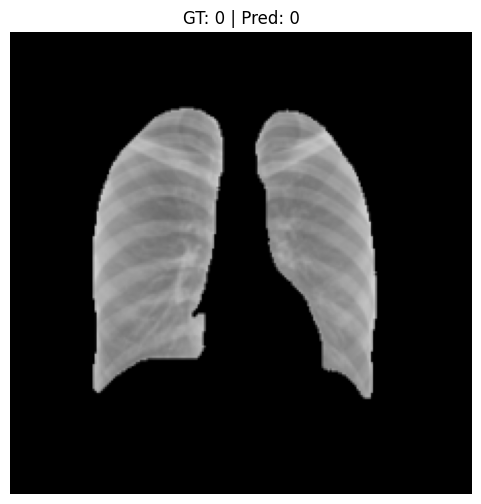

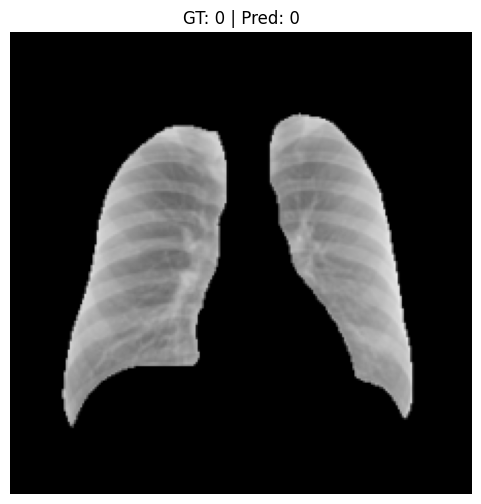

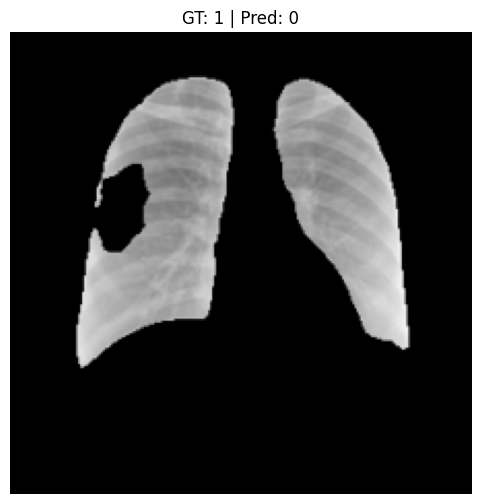

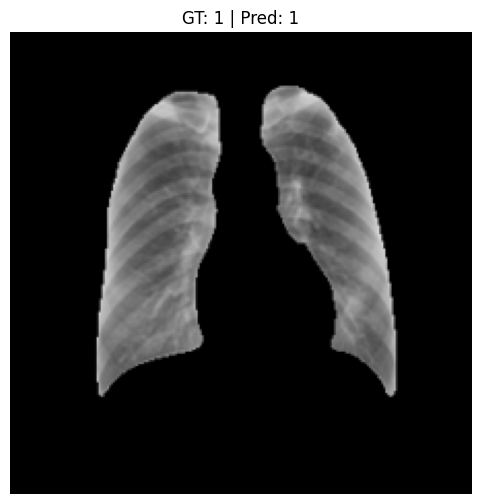

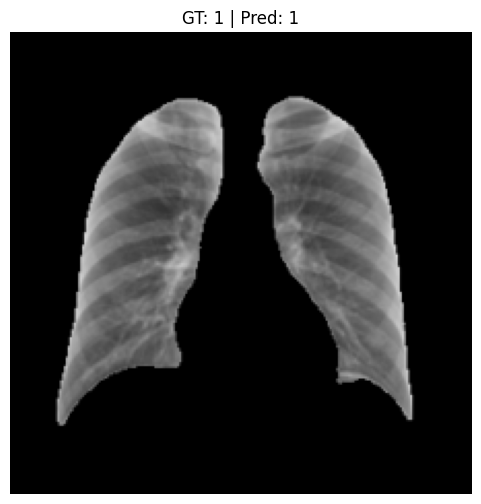

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_names = train_dataset.classes  # ['0', '1'] → 0=Normal, 1=TB

def visualize_predictions_balanced(model, loader, n_per_class=3):
    """
    Shows n_per_class examples for each class in the loader.
    """
    model.eval()
    shown = {0: 0, 1: 0}  # track how many images shown per class
    total_needed = n_per_class * len(shown)

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for i in range(imgs.size(0)):
                gt = labels[i].item()
                if shown[gt] >= n_per_class:
                    continue  # skip if already have enough for this class

                img = imgs[i].cpu().numpy().transpose(1,2,0)  # (H,W,3)
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                plt.figure(figsize=(6,6))
                plt.imshow(img)
                plt.title(f"GT: {class_names[gt]} | Pred: {class_names[preds[i].item()]}")
                plt.axis('off')
                plt.show()

                shown[gt] += 1
                if sum(shown.values()) >= total_needed:
                    return

# Example usage: show 3 examples of Normal and 3 of TB
visualize_predictions_balanced(model, test_loader, n_per_class=3)


**Evaluation Metrics**

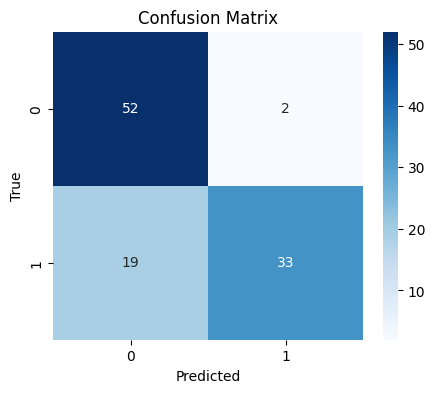

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.96      0.83        54
           1       0.94      0.63      0.76        52

    accuracy                           0.80       106
   macro avg       0.84      0.80      0.80       106
weighted avg       0.84      0.80      0.80       106



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class_names = train_dataset.classes  # ['0', '1'] → 0=Normal, 1=TB
# Collect predictions
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


**Improved model**

**Setup & Dataset (Mandatory after restart)**

In [ ]:
# --------------------
# Imports
# --------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
import os
from collections import Counter

# --------------------
# Device
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------------------
# Paths
# --------------------
masked_lungs_dir = "/content/drive/MyDrive/lung_segmentation_project/masked_lungs_by_class"

# --------------------
# Transforms
# --------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --------------------
# Datasets
# --------------------
train_dataset = datasets.ImageFolder(os.path.join(masked_lungs_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(masked_lungs_dir, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(masked_lungs_dir, "test"), transform=transform)

# --------------------
# Weighted Sampler (to handle imbalance)
# --------------------
targets = [label for _, label in train_dataset.samples]
class_counts = Counter(targets)
print("Train class distribution:", class_counts)

class_weights = [1.0 / class_counts[c] for c in range(len(class_counts))]
sample_weights = [class_weights[label] for label in targets]

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Number of classes:", len(train_dataset.classes))


Device: cuda
Train class distribution: Counter({0: 259, 1: 249})
Number of classes: 2


**Model Definition (Mandatory after restart)**

In [ ]:
# --------------------
# Model
# --------------------
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Use weighted loss (to push recall on TB)
class_weights_tensor = torch.tensor([1.0, 2.0], device=device)  # weight TB class more
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='max',
                                                 factor=0.5,
                                                 patience=2)

**Training Loop (Optional if already trained)**

In [ ]:

# --------------------
# Training Loop
# --------------------
num_epochs = 20
best_val_acc = 0.0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

    # Scheduler step
    scheduler.step(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(masked_lungs_dir, "best_classifier_balanced.pth"))
        print("-> Saved best model with Val Acc:", best_val_acc)

print("Training finished. Best Val Acc:", best_val_acc)

Device: cuda
Train class distribution: Counter({0: 259, 1: 249})
Number of classes: 2
Epoch [1/20]  Train Loss: 0.3864  Train Acc: 0.8012  Val Acc: 0.7556
-> Saved best model with Val Acc: 0.7555555555555555
Epoch [2/20]  Train Loss: 0.1975  Train Acc: 0.9232  Val Acc: 0.7889
-> Saved best model with Val Acc: 0.7888888888888889
Epoch [3/20]  Train Loss: 0.1197  Train Acc: 0.9567  Val Acc: 0.7444
Epoch [4/20]  Train Loss: 0.0710  Train Acc: 0.9823  Val Acc: 0.7778
Epoch [5/20]  Train Loss: 0.0889  Train Acc: 0.9567  Val Acc: 0.5889
Epoch [6/20]  Train Loss: 0.0671  Train Acc: 0.9783  Val Acc: 0.8111
-> Saved best model with Val Acc: 0.8111111111111111
Epoch [7/20]  Train Loss: 0.0277  Train Acc: 0.9921  Val Acc: 0.8778
-> Saved best model with Val Acc: 0.8777777777777778
Epoch [8/20]  Train Loss: 0.0073  Train Acc: 1.0000  Val Acc: 0.8556
Epoch [9/20]  Train Loss: 0.0076  Train Acc: 0.9980  Val Acc: 0.8667
Epoch [10/20]  Train Loss: 0.0073  Train Acc: 1.0000  Val Acc: 0.8778
Epoch [11/2

**Load Best Model (Mandatory after restart)**

In [ ]:
# --------------------
# Load best saved model
# --------------------
model.load_state_dict(torch.load(os.path.join(masked_lungs_dir, "best_classifier_balanced.pth"), map_location=device))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Evaluation (Mandatory after restart)**

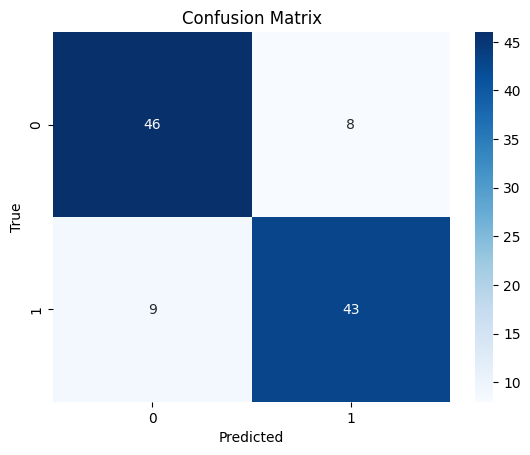

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84        54
           1       0.84      0.83      0.83        52

    accuracy                           0.84       106
   macro avg       0.84      0.84      0.84       106
weighted avg       0.84      0.84      0.84       106



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Test evaluation
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


**Explainability**

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=0bb97226741936f1cc17f614751dbb14423ac3af64d3ba788e9915c80c5debb5
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

data_dir = "/content/drive/MyDrive/lung_segmentation_project/masked_lungs_by_class"  # your processed folder

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

class_names = train_dataset.classes  # ['0','1'] -> 0=Normal, 1=TB
print("Classes:", class_names)


Classes: ['0', '1']


In [ ]:
import torchvision.models as models

def get_classifier(num_classes=2):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [ ]:
# paths to saved models
seg_path = "/content/drive/MyDrive/lung_segmentation_project/unet_best.pth"
clf_path = "/content/drive/MyDrive/lung_segmentation_project/masked_lungs_by_class/best_classifier_balanced.pth"

# load U-Net
model_seg = UNet().to(device)
model_seg.load_state_dict(torch.load(seg_path, map_location=device))
model_seg.eval()

# load classifier
model_clf = get_classifier(num_classes=len(class_names)).to(device)
model_clf.load_state_dict(torch.load(clf_path, map_location=device))
model_clf.eval()

print("✅ Both models loaded successfully")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Both models loaded successfully


The `ModuleNotFoundError: No module named 'pytorch_grad_cam'` indicates that the required library was not found in the current Python environment. This can happen if the runtime session was restarted and the libraries were not re-installed.

To fix this, we need to re-run the cell that installs `grad-cam` and then re-execute the cell that uses it.

In [ ]:
# Re-run the installation cell
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=d3423f9f3bc0a7077d58cd35028bca9c2cf5b263dff863b9b2a61649d4c7318e
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


The `RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn` happens because Grad-CAM needs to calculate gradients with respect to the model's output. However, the code that computes the Grad-CAM is inside a `torch.no_grad()` block, which prevents these gradients from being computed.

To fix this, we need to move the Grad-CAM computation outside the `torch.no_grad()` block.

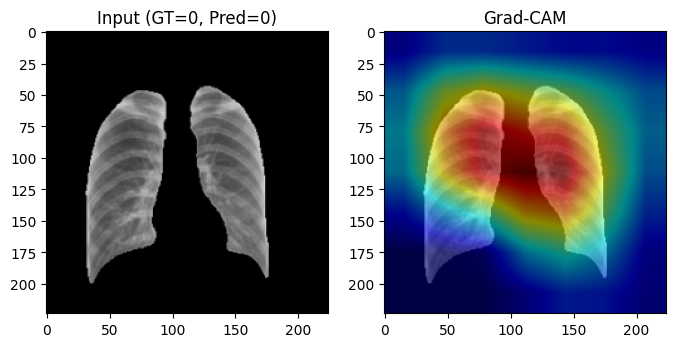

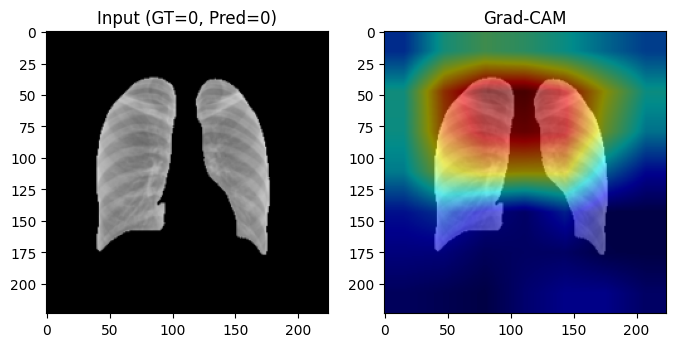

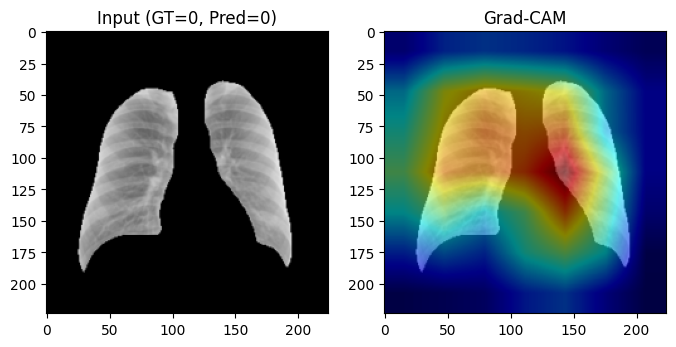

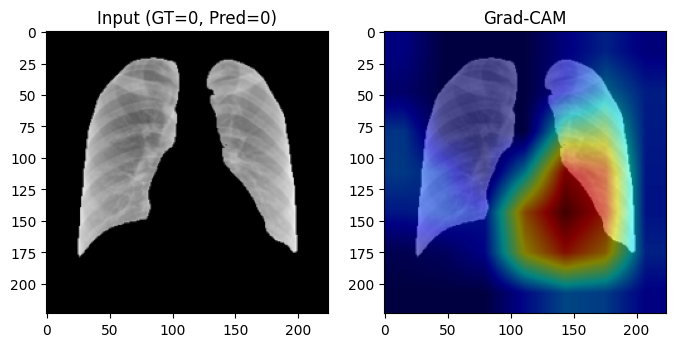

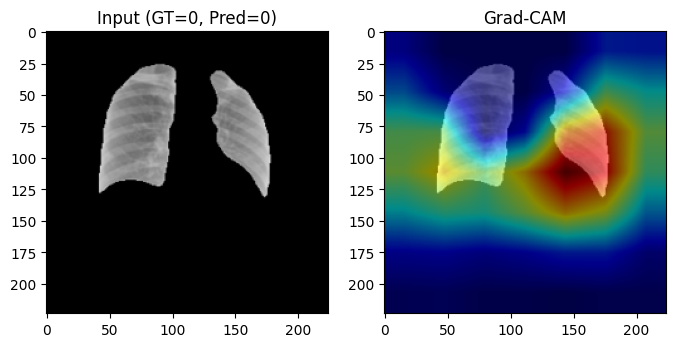

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import numpy as np
import torch

target_layers = [model_clf.layer4[-1]]
cam = GradCAM(model=model_clf, target_layers=target_layers)

def visualize_with_gradcam(model, loader, n=5):
    model.eval()
    imgs_shown = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

        for i in range(imgs.size(0)):
            if preds[i].item() == labels[i].item():  # only correct predictions
                img_tensor = imgs[i].unsqueeze(0)

                grayscale_cam = cam(input_tensor=img_tensor,
                                    targets=[ClassifierOutputTarget(preds[i].item())])
                grayscale_cam = grayscale_cam[0, :]

                # Convert back to numpy image
                img = imgs[i].cpu().numpy().transpose(1, 2, 0)
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

                plt.figure(figsize=(8,4))
                plt.subplot(1,2,1); plt.imshow(img); plt.title(f"Input (GT={labels[i].item()}, Pred={preds[i].item()})")
                plt.subplot(1,2,2); plt.imshow(cam_image); plt.title("Grad-CAM")
                plt.show()

                imgs_shown += 1
                if imgs_shown >= n:
                    return

# Run
visualize_with_gradcam(model_clf, test_loader, n=5)


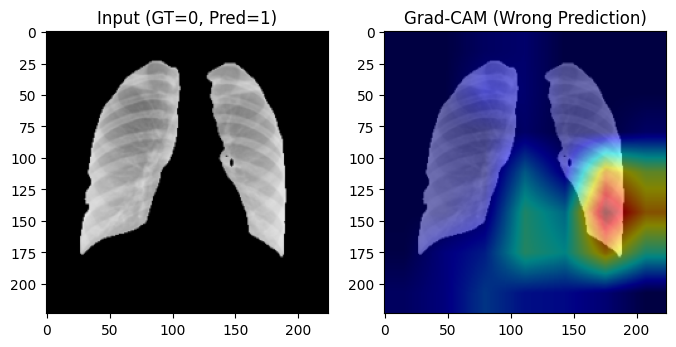

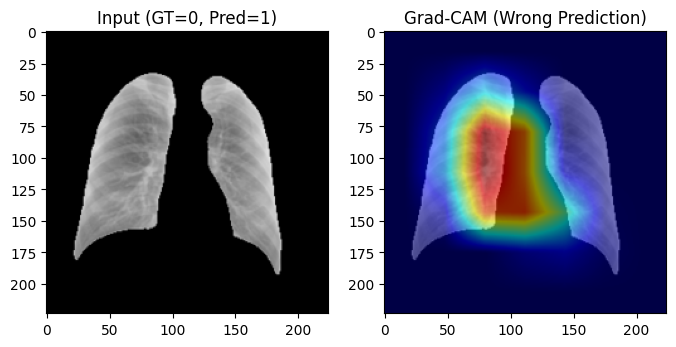

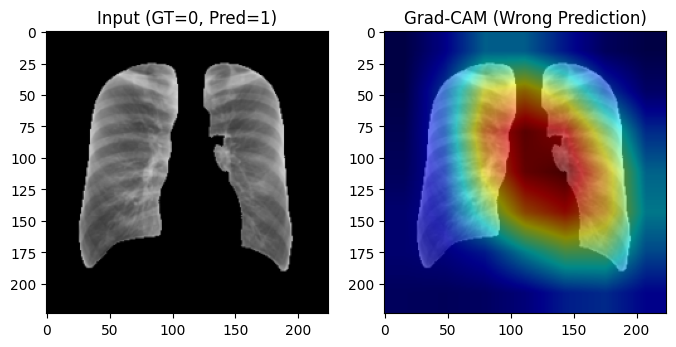

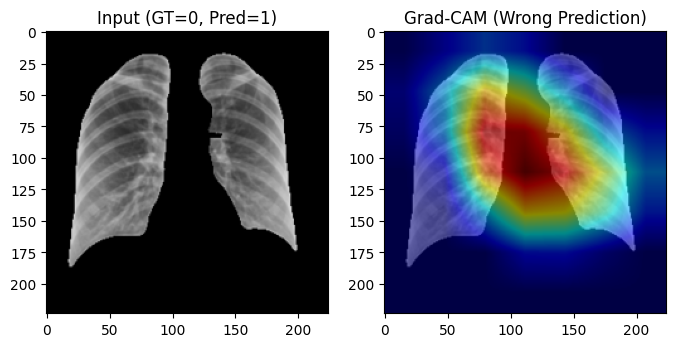

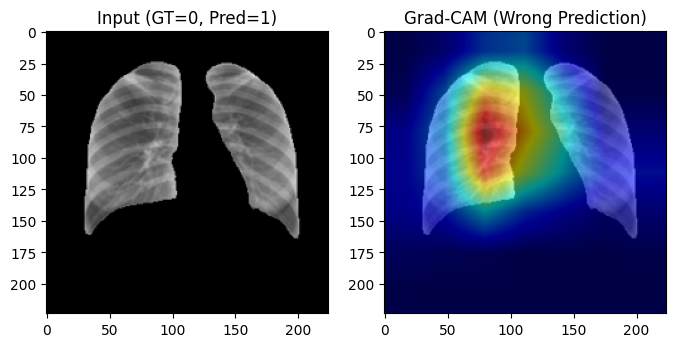

In [ ]:
# Grad-CAM for Misclassified Samples
def visualize_misclassified_with_gradcam(model, loader, n=5):
    model.eval()
    imgs_shown = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward pass to get predictions
        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

        # Loop through the batch
        for i in range(imgs.size(0)):
            if preds[i].item() != labels[i].item():  # Only misclassified
                img_tensor = imgs[i].unsqueeze(0)
                true_label = labels[i].item()
                pred_label = preds[i].item()

                # Grad-CAM requires gradient enabled for input
                img_tensor.requires_grad_(True)
                grayscale_cam = cam(input_tensor=img_tensor,
                                    targets=[ClassifierOutputTarget(pred_label)])
                img_tensor.requires_grad_(False)

                grayscale_cam = grayscale_cam[0, :]

                # Convert image back for plotting
                img = imgs[i].cpu().numpy().transpose(1, 2, 0)
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title(f"Input (GT={true_label}, Pred={pred_label})")

                plt.subplot(1, 2, 2)
                plt.imshow(cam_image)
                plt.title("Grad-CAM (Wrong Prediction)")
                plt.show()

                imgs_shown += 1
                if imgs_shown >= n:
                    return

# Example: Show 5 misclassified images with Grad-CAM
visualize_misclassified_with_gradcam(model_clf, test_loader, n=5)


In [ ]:
!pip install streamlit opencv-python pytorch-grad-cam

  Using cached streamlit-1.50.0-py3-none-any.whl.metadata (9.5 kB)
ERROR: Ignored the following versions that require a different python version: 0.55.2 Requires-Python <3.5
ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


**Website**

In [ ]:
import streamlit as st
import torch
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch.nn as nn
import torchvision.models as models

# -------------------------
# Define U-Net architecture (needed to load state_dict)
# -------------------------
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.center = CBR(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        center = self.center(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(center), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1) # Removed sigmoid here, apply later for binary mask

def get_classifier(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


# -------------------------
# Load trained models
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load segmentation model (U-Net)
model_seg = UNet().to(device) # Instantiate the model
model_seg.load_state_dict(torch.load("/content/drive/MyDrive/lung_segmentation_project/unet_best.pth", map_location=device)) # Load state dict
model_seg.eval()

# Load classification model
model_clf = get_classifier(num_classes=2).to(device) # Instantiate the model
model_clf.load_state_dict(torch.load("/content/drive/MyDrive/lung_segmentation_project/masked_lungs_by_class/best_classifier_balanced.pth", map_location=device)) # Load state dict
model_clf.eval()

# -------------------------
# Define preprocessing
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3), # ResNet expects 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = ["Normal", "TB"]  # extend if you add COVID later

st.title("Chest X-ray Lung Disease Detection")
st.write("Upload a chest X-ray → Segmentation → Classification → Grad-CAM")

# -------------------------
# Upload image
# -------------------------
uploaded_file = st.file_uploader("Upload Chest X-ray", type=["jpg","png","jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Convert to tensor for segmentation
    # Need to convert to grayscale for U-Net input (1 channel)
    img_gray = image.convert("L")
    img_array = np.array(img_gray) / 255.0
    img_tensor_seg = torch.tensor(img_array).unsqueeze(0).unsqueeze(0).float().to(device) # Add batch and channel dims

    # -------------------------
    # Step 1: Lung Segmentation
    # -------------------------
    with torch.no_grad():
        mask_pred_logits = model_seg(img_tensor_seg) # Get logits
        mask_pred = torch.sigmoid(mask_pred_logits).cpu().numpy()[0,0] # Apply sigmoid and convert to numpy
        mask_bin = (mask_pred > 0.5).astype(np.uint8)  # binary mask

    # Resize original color image and mask to match for overlay
    original_img_array = np.array(image.resize((256,256))) # Resize original color image
    mask_bin_resized = cv2.resize(mask_bin, (original_img_array.shape[1], original_img_array.shape[0])) # Resize mask to match

    # Apply mask to original color image
    segmented_img = original_img_array * np.expand_dims(mask_bin_resized, axis=2)

    st.image(segmented_img, caption="Segmented Lungs", use_column_width=True)

    # -------------------------
    # Step 2: Classification
    # -------------------------
    # Use segmented lungs for classification
    # Need to convert segmented image back to PIL for classification transform
    segmented_pil = Image.fromarray(segmented_img.astype(np.uint8))
    input_tensor_clf = transform(segmented_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model_clf(input_tensor_clf)
        _, pred = torch.max(outputs, 1)

    st.write(f"### Prediction: **{class_names[pred.item()]}**")

    # -------------------------
    # Step 3: Grad-CAM
    # -------------------------
    # Grad-CAM needs gradients, so it should not be in torch.no_grad()
    target_layers = [model_clf.layer4[-1]]
    cam = GradCAM(model=model_clf, target_layers=target_layers)

    # Compute Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor_clf,
                        targets=[ClassifierOutputTarget(pred.item())])[0, :]

    # Resize segmented image to match CAM size for overlay
    segmented_img_resized_for_cam = cv2.resize(segmented_img.astype(np.uint8), (grayscale_cam.shape[1], grayscale_cam.shape[0]))

    cam_image = show_cam_on_image(segmented_img_resized_for_cam, grayscale_cam, use_rgb=True)
    st.image(cam_image, caption="Grad-CAM Heatmap", use_column_width=True)

ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [ ]:
!pip install streamlit

  Using cached streamlit-1.50.0-py3-none-any.whl.metadata (9.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.4 MB/s eta 0:00:00


In [ ]:
# app.py
import streamlit as st
import torch
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch.nn as nn
import torchvision.models as models
import traceback
import os

st.set_page_config(layout="wide")
st.title("🫁 Chest X-ray — Segmentation + Classification + Grad-CAM")

# -------------------------
# Config: set these paths
# -------------------------
UNET_PATH = "/content/drive/MyDrive/lung_segmentation_project/unet_best.pth"
CLF_PATH  = "/content/drive/MyDrive/lung_segmentation_project/masked_lungs_by_class/best_classifier_balanced.pth"
# -------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
st.write(f"Using device: **{device}**")

# -------------------------
# Model architectures
# -------------------------
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.center = CBR(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.out = nn.Conv2d(64, 1, kernel_size=1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        center = self.center(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(center), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1)  # logits


def get_classifier(num_classes=2):
    # use weights-based constructor for modern torchvision
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# -------------------------
# Robust loader util
# -------------------------
def robust_load_model(model_inst, path, map_location=device):
    """
    If path contains a state_dict (dict), load into model_inst.
    If path contains a full model object, return it.
    Also handles 'module.' prefix from DataParallel.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model file not found: {path}")
    loaded = torch.load(path, map_location=map_location)
    # If user saved full model object (not recommended), loaded will be nn.Module
    if isinstance(loaded, nn.Module):
        return loaded.to(map_location)
    # If it's a dict (state_dict) load into provided model
    if isinstance(loaded, dict):
        try:
            model_inst.load_state_dict(loaded)
        except RuntimeError as e:
            # try strip "module." prefixes
            new_state = {}
            for k,v in loaded.items():
                new_key = k.replace("module.","") if k.startswith("module.") else k
                new_state[new_key] = v
            model_inst.load_state_dict(new_state)
        return model_inst.to(map_location)
    # fallback: unknown type
    raise RuntimeError("Unsupported model file format.")

# -------------------------
# Load models (with UI feedback)
# -------------------------
load_error = None
try:
    with st.spinner("Loading segmentation model..."):
        model_seg = UNet()
        model_seg = robust_load_model(model_seg, UNET_PATH)
        model_seg.eval()
    with st.spinner("Loading classifier model..."):
        model_clf = get_classifier(num_classes=2)
        model_clf = robust_load_model(model_clf, CLF_PATH)
        model_clf.eval()
    st.success("Models loaded successfully ✅")
except Exception as e:
    load_error = e
    st.error("Error loading models — see details below. Fix file paths or saved format.")
    st.text(traceback.format_exc())

if load_error:
    st.stop()

# -------------------------
# Preprocessing (consistent 224x224)
# -------------------------
CLASS_INPUT_SIZE = 224
SEG_INPUT_SIZE = 224

transform_clf = transforms.Compose([
    transforms.Resize((CLASS_INPUT_SIZE, CLASS_INPUT_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = ["Normal", "TB"]

# -------------------------
# UI: upload and pipeline
# -------------------------
uploaded = st.file_uploader("Upload a chest X-ray (jpg/png)", type=["jpg","png","jpeg"])
if uploaded is None:
    st.info("Upload a chest X-ray image to run segmentation + classification + Grad-CAM.")
    st.stop()

try:
    image = Image.open(uploaded).convert("RGB")
    st.image(image, caption="Uploaded image", use_column_width=True)

    # Prepare segmentation input: grayscale, resized to SEG_INPUT_SIZE
    img_gray = image.convert("L").resize((SEG_INPUT_SIZE, SEG_INPUT_SIZE))
    img_gray_arr = np.array(img_gray).astype(np.float32) / 255.0
    img_tensor_seg = torch.from_numpy(img_gray_arr).unsqueeze(0).unsqueeze(0).to(device)  # (1,1,H,W)

    # Run segmentation (model outputs logits)
    with torch.no_grad():
        mask_logits = model_seg(img_tensor_seg)          # (1,1,H,W)
        mask_probs = torch.sigmoid(mask_logits).cpu().numpy()[0,0]  # (H,W) in [0,1]

    # Binarize mask
    mask_bin = (mask_probs > 0.5).astype(np.uint8)

    # Resize original color image to SEG_INPUT_SIZE for consistent overlay
    orig_resized = np.array(image.resize((SEG_INPUT_SIZE, SEG_INPUT_SIZE))).astype(np.uint8)

    # If mask is all zeros, warn and continue (we'll still classify using masked image fallback)
    if mask_bin.sum() == 0:
        st.warning("Segmentation returned an empty mask (all zeros). The app will continue but consider inspecting the U-Net output.")
    # Build segmented RGB image (multiply)
    segmented_img = (orig_resized.astype(np.float32) / 255.0) * np.expand_dims(mask_bin.astype(np.float32), axis=2)  # float32 in [0,1]

    # Show segmentation and mask
    st.subheader("Segmentation")
    col1, col2 = st.columns(2)
    col1.image(orig_resized, caption="Resized Original (for pipeline)", use_column_width=True)
    col2.image((mask_bin*255).astype(np.uint8), caption="Predicted Mask (binary)", use_column_width=True)

    st.subheader("Masked Lungs (applied to original)")
    st.image((segmented_img*255).astype(np.uint8), use_column_width=True)

    # -------------------------
    # Classification (on segmented image)
    # -------------------------
    segmented_pil = Image.fromarray((segmented_img*255).astype(np.uint8))
    input_tensor_clf = transform_clf(segmented_pil).unsqueeze(0).to(device)  # (1,3,224,224)

    with torch.no_grad():
        outputs = model_clf(input_tensor_clf)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, dim=1)
        pred_label = int(pred.item())
        pred_conf = float(conf.item())

    st.markdown(f"### Prediction: **{class_names[pred_label]}**  (confidence: {pred_conf:.3f})")

    # -------------------------
    # Grad-CAM
    # -------------------------
    # Grad-CAM expects float [0,1] image for overlay
    try:
        target_layers = [model_clf.layer4[-1]]
        cam = GradCAM(model=model_clf, target_layers=target_layers)

        # Make sure the image passed to show_cam_on_image is float32 in [0,1]
        # We'll use the segmented_img normalized to [0,1]
        cam_input = input_tensor_clf  # already on device

        grayscale_cam = cam(input_tensor=cam_input, targets=[ClassifierOutputTarget(pred_label)])[0, :]  # (H,W)

        # convert segmented_img to match cam shape and range
        seg_for_cam = cv2.resize(segmented_img.astype(np.float32), (grayscale_cam.shape[1], grayscale_cam.shape[0]))
        # ensure float32 in [0,1]
        seg_for_cam = np.clip(seg_for_cam, 0.0, 1.0).astype(np.float32)

        cam_image = show_cam_on_image(seg_for_cam, grayscale_cam, use_rgb=True)
        st.subheader("Grad-CAM on Segmented Lungs")
        st.image((cam_image*255).astype(np.uint8), use_column_width=True)
    except Exception as e:
        st.error("Error while computing Grad-CAM. Details:")
        st.text(traceback.format_exc())

except Exception as e:
    st.error("Pipeline error — see details below:")
    st.text(traceback.format_exc())

ModuleNotFoundError: No module named 'pytorch_grad_cam'



---



---



---


**Deplyment**


---


---



---



In [1]:
# in a Colab cell
!pip install -q streamlit pyngrok pytorch-grad-cam



ERROR: Ignored the following versions that require a different python version: 0.55.2 Requires-Python <3.5
ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [2]:
!pip install pytorch-grad-cam


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [3]:
!pip install streamlit opencv-python-headless pillow torchvision torch


  Using cached streamlit-1.52.1-py3-none-any.whl.metadata (9.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.8 MB/s eta 0:00:00


In [4]:
# Re-run the installation cell
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=8410230302415502d94e0d97517e709812e3da07457b965637ad43ea26028947
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [5]:
%%writefile app.py
# app.py - Streamlit app for: Upload -> Segmentation -> Classification -> Grad-CAM
import streamlit as st
import torch, os, traceback
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch.nn as nn
import torchvision.models as models

st.set_page_config(layout="wide")
st.title("🫁 Chest X-ray — Segmentation + Classification + Grad-CAM")

# -------------------------
# USER CONFIG: model paths
# -------------------------
UNET_PATH = "/content/drive/MyDrive/lung_segmentation_project/unet_best.pth"
CLF_PATH  = "/content/drive/MyDrive/lung_segmentation_project/masked_lungs_by_class/best_classifier_balanced.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
st.write(f"Using device: **{device}**")

# -------------------------
# Model definitions
# -------------------------
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.center = CBR(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.out = nn.Conv2d(64, 1, kernel_size=1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        center = self.center(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(center), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1)  # logits

def get_classifier(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# -------------------------
# Robust loader helper
# -------------------------
def robust_load_model(model_inst, path, map_location=device):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model not found: {path}")
    loaded = torch.load(path, map_location=map_location)
    if isinstance(loaded, nn.Module):
        return loaded.to(map_location)
    if isinstance(loaded, dict):
        try:
            model_inst.load_state_dict(loaded)
        except RuntimeError:
            new_state = {}
            for k,v in loaded.items():
                new_key = k.replace("module.","") if k.startswith("module.") else k
                new_state[new_key] = v
            model_inst.load_state_dict(new_state)
        return model_inst.to(map_location)
    raise RuntimeError("Unsupported model file format.")

# -------------------------
# Load models
# -------------------------
try:
    with st.spinner("Loading U-Net segmentation model..."):
        seg_model = UNet()
        seg_model = robust_load_model(seg_model, UNET_PATH)
        seg_model.eval()
    with st.spinner("Loading classifier model..."):
        clf_model = get_classifier(num_classes=2)
        clf_model = robust_load_model(clf_model, CLF_PATH)
        clf_model.eval()
    st.success("Models loaded ✅")
except Exception as e:
    st.error("Error loading models. Check paths.")
    st.text(traceback.format_exc())
    st.stop()

# -------------------------
# Preprocessing
# -------------------------
IMG_SIZE = 224
transform_clf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
class_names = ["Normal", "TB"]

# -------------------------
# UI - Upload
# -------------------------
uploaded = st.file_uploader("Upload a chest X-ray (jpg/png)", type=["jpg","png","jpeg"])
if uploaded is None:
    st.info("Upload a chest X-ray to begin.")
    st.stop()

try:
    # Load image and force to 224x224
    image = Image.open(uploaded).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    st.image(image, caption="Original (224x224)", use_container_width=True)

    # -------------------------
    # Step 1: Segmentation
    # -------------------------
    img_gray = image.convert("L")
    img_gray_arr = np.array(img_gray).astype(np.float32) / 255.0
    input_seg = torch.from_numpy(img_gray_arr).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,224,224]

    with torch.no_grad():
        logits_mask = seg_model(input_seg)
        probs_mask = torch.sigmoid(logits_mask).cpu().numpy()[0,0]

    mask_bin = (probs_mask > 0.5).astype(np.uint8)

    # Overlay segmented image
    orig_resized = np.array(image).astype(np.uint8)
    segmented_img = (orig_resized.astype(np.float32)/255.0) * np.expand_dims(mask_bin.astype(np.float32), axis=2)

    col1, col2 = st.columns(2)
    col1.subheader("Predicted binary mask")
    col1.image((mask_bin*255).astype(np.uint8), use_container_width=True)
    col2.subheader("Masked lungs")
    col2.image((segmented_img*255).astype(np.uint8), use_container_width=True)

    # -------------------------
    # Step 2: Classification
    # -------------------------
    segmented_pil = Image.fromarray((segmented_img*255).astype(np.uint8))
    input_clf = transform_clf(segmented_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = clf_model(input_clf)
        probs = torch.softmax(logits, dim=1)
        conf, pred_idx = torch.max(probs, dim=1)
        pred_label = int(pred_idx.item()); pred_conf = float(conf.item())

    st.markdown(f"### Prediction: **{class_names[pred_label]}**  (confidence: {pred_conf:.3f})")

    # -------------------------
    # Step 3: Grad-CAM
    # -------------------------
    try:
        target_layers = [clf_model.layer4[-1]]
        cam = GradCAM(model=clf_model, target_layers=target_layers)

        grayscale_cam = cam(input_tensor=input_clf, targets=[ClassifierOutputTarget(pred_label)])[0, :]
        seg_for_cam = np.array(segmented_pil).astype(np.float32) / 255.0
        cam_image = show_cam_on_image(seg_for_cam, grayscale_cam, use_rgb=True)

        st.subheader("Grad-CAM (on segmented lungs)")
        st.image(cam_image, use_container_width=True)
    except Exception:
        st.error("Grad-CAM failed.")
        st.text(traceback.format_exc())

except Exception:
    st.error("Pipeline error.")
    st.text(traceback.format_exc())


Writing app.py


In [6]:
!pkill -f ngrok


In [7]:
!nohup streamlit run app.py --server.port 8501 > /content/streamlit.log 2>&1 &


In [8]:
!pip install pyngrok

  Using cached pyngrok-7.5.0-py3-none-any.whl.metadata (8.1 kB)


In [9]:
from pyngrok import ngrok
import os

# Replace "YOUR_AUTHTOKEN" with your actual ngrok authtoken
# It's recommended to store this in Colab secrets for security.
# Access it like: ngrok.set_auth_token(os.environ.get("NGROK_AUTHTOKEN"))
ngrok.set_auth_token("33XqIy2olHqlVjZ57vOpx5Tdt6W_6yGWwFim8vdyV1Y19bzFg")

# Now try connecting again
public_url = ngrok.connect(8501)
print(public_url)

NgrokTunnel: "https://twiggier-noneditorially-joellen.ngrok-free.dev" -> "http://localhost:8501"


The error message indicates that `ngrok` requires an authentication token. You can get a free token by signing up on the [ngrok website](https://dashboard.ngrok.com/signup). Once you have your token, you can add it using `ngrok.set_auth_token()`.

**------------------------------------------------------------------------------------------**